In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
%matplotlib inline
pd.options.display.max_columns = 150

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# Importing DataFrame and removing columns/null-values that created index problems
# (similar to Guided Example DF):

data = pd.read_csv("LoanStats3d.csv", skipinitialspace = True, header = 1, engine = 'python', skipfooter = 2)

data.drop(['member_id', 'id', 'url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)


In [3]:
# Giving the 'loan_status' column some values that we can refer to later:

data.replace({"loan_status":{"Charged Off": 0,
                             "Current": 1,
                             "Default":  2,
                             "Fully Paid":  3,
                             "In Grace Period":  4,
                             "Late (16-30 days)":  5,
                             "Late (31-120 days)":  6}}, inplace = True)
data.loan_status.astype('int64')

0         1
1         3
2         3
3         3
4         1
5         3
6         3
7         1
8         1
9         1
10        3
11        3
12        3
13        1
14        1
15        3
16        1
17        1
18        3
19        3
20        1
21        1
22        3
23        1
24        3
25        3
26        1
27        1
28        3
29        1
         ..
421065    3
421066    0
421067    3
421068    3
421069    1
421070    1
421071    3
421072    3
421073    3
421074    3
421075    1
421076    0
421077    3
421078    3
421079    3
421080    3
421081    3
421082    3
421083    3
421084    3
421085    3
421086    0
421087    3
421088    3
421089    0
421090    3
421091    3
421092    0
421093    0
421094    3
Name: loan_status, Length: 421095, dtype: int64

In [4]:
data.drop(data.select_dtypes(include = ['object']).keys(), axis = 1, inplace = True)
data.dropna(how = 'any', axis = 1, inplace = True)

In [5]:
# Making a copy of the df so we can assign one to the target data (with loan status info) and one for the training
# data without the loan status info.

data2 = data.copy()

# Dropping the last two problematic rows:

data2 = data2[:-2]
data = data[:-2]
data.keys()

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'annual_inc', 'loan_status', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_lie

#### Looking at important elements and implementing the model:

In order to see what attributes will be most important for consolidating our data, it will be helpful to look at a correlation matrix / heatmap to see where values are correlating (or perhaps not correlating), with each other.

I've tried to isolate the values that are not related to payment amount or outstanding balance.  My guess is that loan status would be quite difficult to predict without using these variables since they are intrinsically related, but I'll give it a shot below.

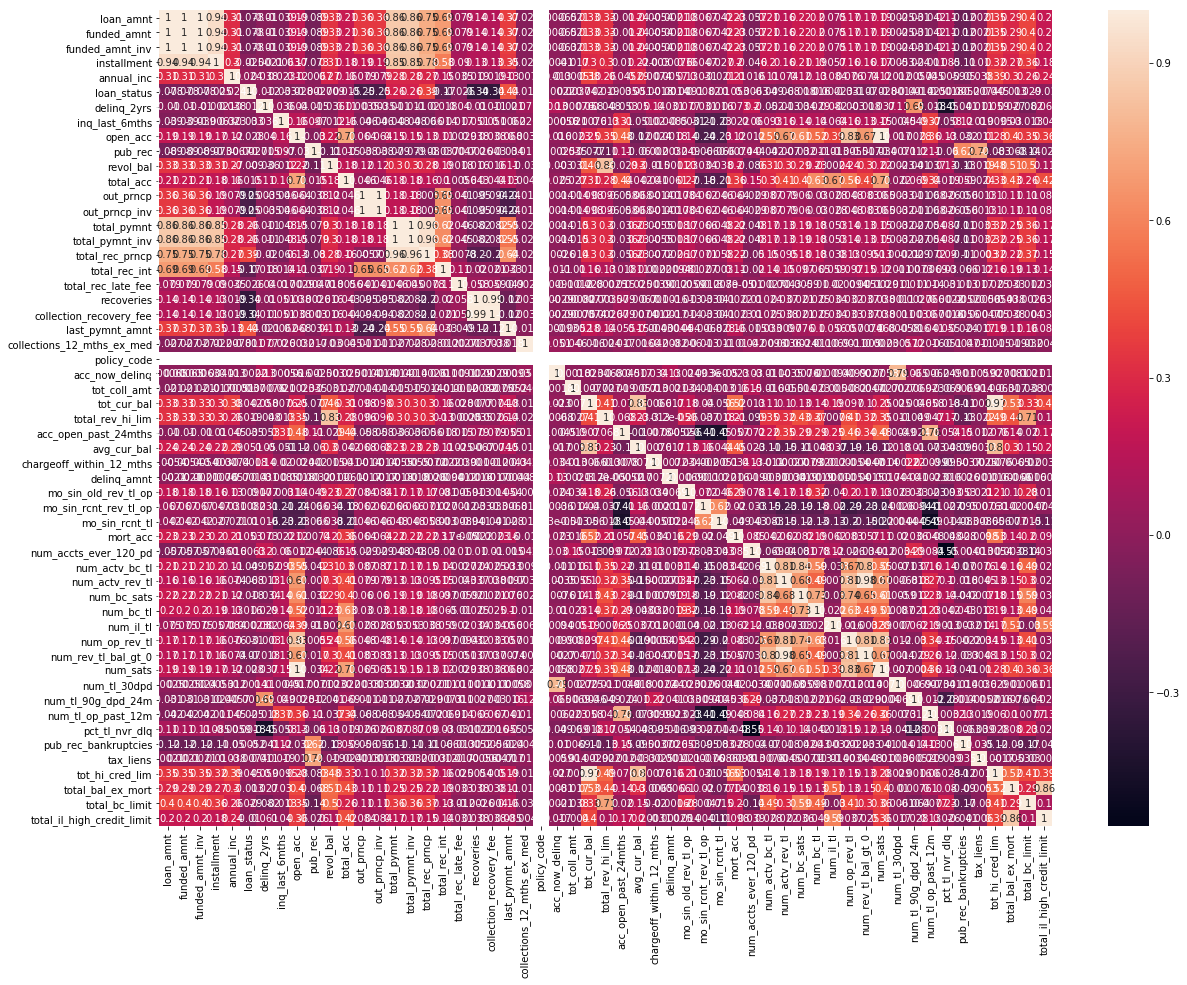

In [7]:
# Looking at a heatmap to see any correlations:

fig, (ax) = plt.subplots(figsize = (20, 15))
sns.heatmap(data.corr(), annot = True)

In [6]:
# Mainly for reference, but at least listing some of the attributes here which dispaly correlation
# in the heatmap above. 

delta = data[['delinq_2yrs', 'inq_last_6mths', 'revol_bal', 'total_acc', 'acc_open_past_24mths',
             'num_accts_ever_120_pd', 'num_actv_bc_tl','num_actv_rev_tl', 'num_bc_sats', 
             'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
             'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'mort_acc', 'pct_tl_nvr_dlq',]]

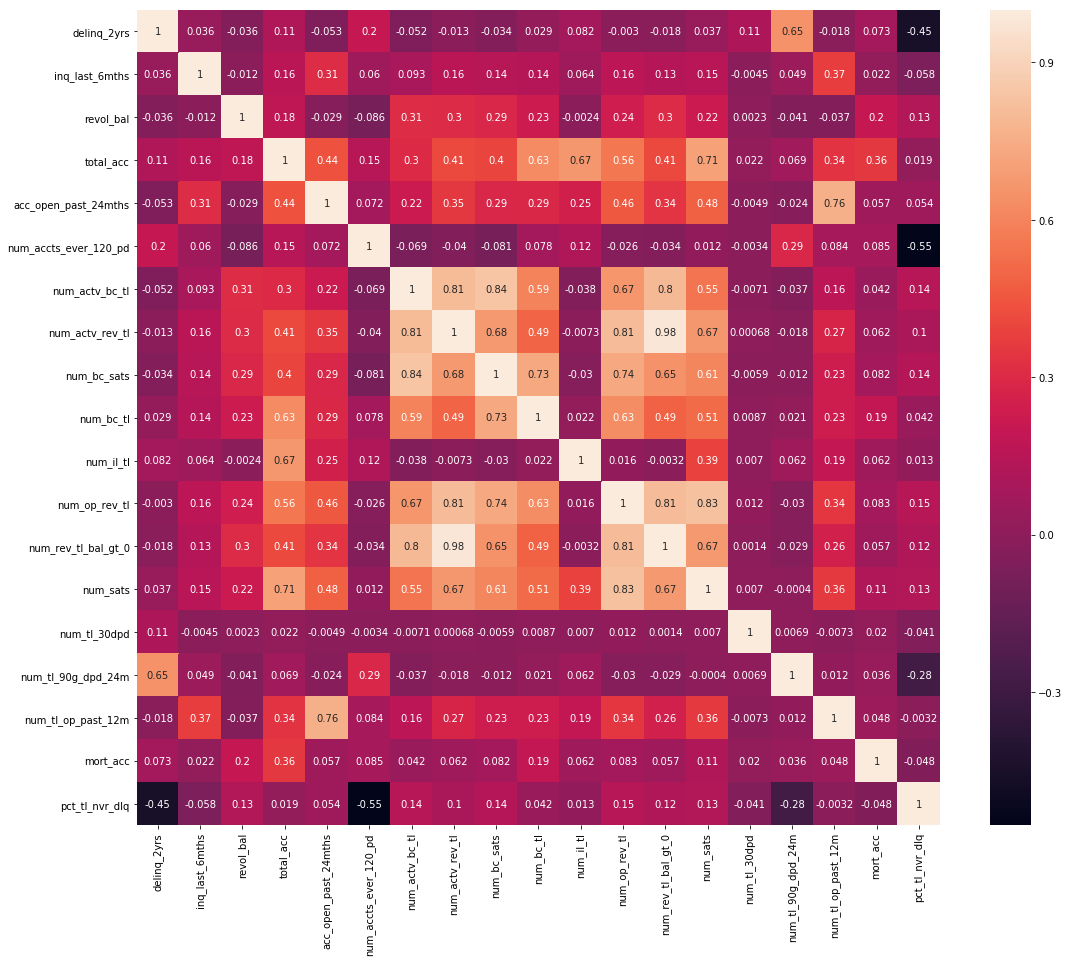

In [9]:
fig, (ax) = plt.subplots(figsize = (18, 15))
sns.heatmap(delta.corr(), annot = True)

In [28]:
def random_forest_uno(target):
    
    rfc = ensemble.RandomForestClassifier()

    X = data[['pub_rec', 'inq_last_6mths', 'revol_bal', 'num_sats', 'total_acc', 'acc_open_past_24mths',
             'num_accts_ever_120_pd', 'num_actv_bc_tl','num_actv_rev_tl', 'num_bc_sats', 
             'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_30dpd',
             'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq']]
    Y = data2[target].values

    rfc.fit(X, Y)

    return cross_val_score(rfc, X, Y, cv = 10)

In [29]:
random_forest_uno('loan_status')

array([0.48341367, 0.48796068, 0.48483769, 0.48613156, 0.48356685,
       0.48629714, 0.48337608, 0.48386254, 0.4811314 , 0.48210511])

In [30]:
random_forest_uno('inq_last_6mths')

array([0.99734049, 0.99712678, 0.99840897, 0.99731655, 0.99764901,
       0.99731649, 0.99805267, 0.99764879, 0.99786254, 0.99743504])

So, it looks like if we look at credit inquiries within the past 6 months (cell right above), then using columns related to delinquencies in accounts and payments, you can see predictive capabilities. Loan status, however, is less predictable given these columns.

In the cells below, I will try to narrow the data even further to see how that aids or hinders our predictive accuracy. 

In [47]:
def random_forest_due(target):

    rfc_1 = ensemble.RandomForestClassifier()
    
    X1 = data[['pub_rec', 'revol_bal', 'acc_open_past_24mths',
             'num_accts_ever_120_pd', 'num_actv_bc_tl','num_actv_rev_tl', 'num_tl_30dpd',
             'num_tl_90g_dpd_24m', 'num_tl_op_past_12m']]
    Y1 = data2[target].values

    rfc_1.fit(X1, Y1)

    return cross_val_score(rfc_1, X1, Y1, cv = 10)

In [48]:
random_forest_due('loan_status')

array([0.43976919, 0.44262918, 0.43948137, 0.43991926, 0.44291142,
       0.44169754, 0.44067636, 0.44047308, 0.43755195, 0.43738571])

In [49]:
random_forest_due('inq_last_6mths')

array([0.5251585 , 0.52914777, 0.52748688, 0.52564711, 0.52768938,
       0.5289843 , 0.52546961, 0.52828575, 0.52747827, 0.52638579])

In [50]:
def random_forest_tre(target):

    rfc_2 = ensemble.RandomForestClassifier()
    
    X2 = data[['pct_tl_nvr_dlq', 'num_sats', 'num_bc_sats', ]]
    Y2 = data2[target].values

    rfc_2.fit(X2, Y2)

    return cross_val_score(rfc_2, X2, Y2, cv = 10)

In [51]:
random_forest_tre('loan_status')

array([0.52382875, 0.52664324, 0.52589585, 0.52621705, 0.52607457,
       0.52802318, 0.52329724, 0.52516209, 0.52767948, 0.52575581])

In [62]:
def random_forest_x(target):
    
    rfc_x = ensemble.RandomForestClassifier()
    
    Xx = data
    Yx = data2[target].values

    rfc_x.fit(Xx, Yx)

    return cross_val_score(rfc_x, Xx, Yx, cv = 10)

In [63]:
random_forest_x('loan_status')

array([0.99836155, 0.99890767, 0.99843271, 0.99831394, 0.99916884,
       0.99869383, 0.99798138, 0.99893129, 0.9988363 , 0.99905004])

Above, I tried to include columns that, with an instance of affirmative data, would indicate one end of the spectrum or the other (i.e. whether someone with a delinquent account would have these attribuves or vice versa).  I started with a few columns and kept working my way to adding the whole dataset, comparing cv scores along the way.   It looks like using the dataset as a whole was the best option.  I did, however, remove a few more columns than the guided example did, since I removed any column that was classified as an object datatype. In that sense, this dataset contains less attributes than that of the guided example. 